<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario de Ciencia de Datos (<i>Data Science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Módulo 6: ejemplos de algoritmos de _TD learning_

En este _notebook_ cargaremos algunos ejemplos de los algoritmos de _TD learning_ vistos en el módulo didáctico asociado. 

En la primera parte veremos el método de predicción TD(0) y después nos centraremos en SARSA y Q-learning. En todos los ejemplos emplearemos el entorno __GridWorld__ (en castellano, 'cuadrícula') como referencia, para facilitar la comparación entre métodos y así podernos centrar en el desarrollo de los algoritmos.

## 1. Entorno __GridWorld__

El entorno __GridWorld__ consiste en un agente que se mueve en una cuadrícula 3 × 4. En cada paso, el agente tiene cuatro opciones de acción o movimiento: arriba, abajo, derecha e izquierda. El juego termina cuando el agente se encuentra en una celda que no permite más movimientos. Tenemos dos entornos __*standard_grid*__ y __*negative_grid*__. 

En el entorno *standard_grid*, el agente recibe una recompensa igual a 1 cuando pasa por la celda (0,3). Por el contrario, cuando el agente pasa por la celda (1,3) recibe una recompensa igual a –1. 

El entorno *negative_grid* es parecido al *standard_grid*, pero en este entorno se penaliza al agente por cada movimiento que hace. Es decir, recibe una recompensa negativa para cada movimiento. Este último entorno se usará para la implementación de SARSA y Q-learning. 

El código para implementar este entorno, que se encuentra disponible en el fichero adjunto `gridWorldGame.py`, ha sido adaptado del siguiente enlace:
https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl

## 2. TD(0)

En este apartado ejecutaremos el método TD(0) para el entorno __GridWorld__ en su versión `standard_grid`.


En primer lugar, cargaremos el entorno __GridWorld__ e inicializaremos los parámetros del algoritmo necesarios para determinar su fórmula de actualización.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid, print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1

## 2.1. Inicialización
En este apartado vamos a hacer todas aquellas operaciones necesarias para ejecutar el algoritmo. En primer lugar, definimos un valor de épsilon ($\epsilon$) para las acciones aleatorias. Esta parte del código nos sirve para asegurar que se visiten todos los estados durante la ejecución de los pasos del algoritmo (es decir, la exploración).

In [2]:
def random_action(a, eps=0.1):
    # epsilon-soft para asegurar que se visiten todos los estados
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

A continuación, vamos a posicionar nuestro agente en su estado inicial. Definiremos también los estados, las recompensas (en inglés, _rewards_) y las acciones.

In [3]:
def play_game(grid, policy):
    # retorna una lista de estados y los rewards correspondientes
    # inicia en el estado designado
    s = (2, 0)
    grid.set_state(s)
    states_and_rewards = [(s, 0)] # lista de las parejas (estado, reward)
    while not grid.game_over():
        a = policy[s]
        a = random_action(a)
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s, r))
    
    return states_and_rewards

Para poder verificar el entorno, podemos visualizar en la pantalla la estructura de nuestra cuadrícula (de tamañao 4 × 4) y los valores de recompensa asociados a cada posición.

In [4]:
grid = standard_grid()

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


A continuación, definiremos la política inicial y la imprimiremos para visualizarla en la cuadrícula.

In [5]:
# state -> action
policy = {
  (2, 0): 'U',
  (1, 0): 'U',
  (0, 0): 'R',
  (0, 1): 'R',
  (0, 2): 'R',
  (1, 2): 'R',
  (2, 1): 'R',
  (2, 2): 'R',
  (2, 3): 'U',
}

# politica inicial
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


Seguidamente, procederemos a inicializar los valores de $V(s)$ e imprimirlos en pantalla para poder comprobar y verificar el funcionamiento.

In [6]:
V = {}
states = grid.all_states()

for s in states:
    V[s] = 0

# inicializar el valor para todos los estados en la cuadricula
print_values(V, grid)

---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


## 2.2. Implementación del algoritmo TD(0)

En este apartado vamos a implementar el algoritmo TD(0), que se ejecutará de forma iterativa hasta su convergencia.

In [7]:
for it in range(1000):
    # genera un episodio usando pi
    states_and_rewards = play_game(grid, policy)
    
    # la primera pareja (s, r) es el estado inicial,y lo ponemos a 0
    # dado que no tenemos un reward, para empezar de forma simple.
    # la última pareja (s, r) es el estado terminal y el reward final.
    # el valor del estado terminal es 0 por definición, así que no nos interesa actualizarlo.
    for t in range(len(states_and_rewards) - 1):
        s, _ = states_and_rewards[t]
        s2, r = states_and_rewards[t+1]
        # actualizaremos V(s) al fin de cada episodio
        V[s] = V[s] + ALPHA*(r + GAMMA*V[s2] - V[s])

Finalmente, imprimiremos los valores finales y la política final.

In [8]:
print("final values:")
print_values(V, grid)

print("\nfinal policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.74| 0.84| 0.97| 0.00|
---------------------------
 0.67| 0.00|-0.95| 0.00|
---------------------------
 0.61|-0.52|-0.76|-0.96|

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


## 3. SARSA

En este apartado, implementaremos el método SARSA para resolver el entorno GridWorld. 

## 3.1. Inicialización

Cargaremos el entorno __GridWorld__ e inicializaremos los parámetros del algoritmo que aparecen en su fórmula de actualización.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid, print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1

Seguidamente, necesitaremos definir el `argmax(key)` y el `max(value)`, que son variables que nos sirven para la implementación del algoritmo.

In [10]:
def max_dict(d):
    # retorna el argmax (key) y max (value) de un diccionario
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    
    return max_key, max_val

Al igual que en el ejemplo anterior, continuamos con la inicialización de las acciones aleatorias.

In [11]:
def random_action(a, eps=0.1):
    # epsilon-soft para asegurar que se visiten todos los estados
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

En esta caso, vamos a utilizar el entorno __*negative_grid*__ que implementa una penalización (recompensa negativa) por cada movimiento. De esta forma, se indica al agente que debe encontrar el camino más corto para resolver el problema (es decir, la política óptima).

In [12]:
grid = negative_grid(step_cost=-0.1)

# emprimir rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


## 3.2. Implementación del algoritmo SARSA

A continuación, procederemos a la implementación del algoritmo. Es interesante notar que no vamos a inicializar la política, sino que inicializaremos los valores de $Q$ más recientes.

In [13]:
# initializar Q(s,a)
Q = {}
states = grid.all_states()

for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0

# valores iniciales de Q para todos los estado en la cuadicula
print(Q)

{(0, 1): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (1, 2): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (0, 0): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 3): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 0): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (1, 3): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (1, 0): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 2): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (0, 3): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (0, 2): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 1): {'D': 0, 'R': 0, 'U': 0, 'L': 0}}


Crearemos ahora las variables `update_counts` y `update_counts_sa`, que nos serviran para saber cuantas veces actualizaremos los valores de $Q(s)$.

In [14]:
update_counts = {}
update_counts_sa = {}

for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        update_counts_sa[s][a] = 1.0

Implementaremos, en el siguiente código, los pasos del algoritmo SARSA, que se ejecutará de forma iterativa hasta su convergencia.

In [15]:
# repetir hasta la convergencia
t = 1.0
deltas = []

for it in range(10000):
    if it % 100 == 0:
        t += 1e-2
    if it % 2000 == 0:
        print("iteration:", it)

    # en lugar de generar un episodio, jugaremos un episodio y lo mandaremos en loop, como aquí abajo

    s = (2, 0) # start state
    grid.set_state(s)

    # la primera (s,r) es el estado inicial y vale 0
    # (dado que no tenemos un reward), para empezar el juego de manera facil.
    # la ultima (s, r) es el estado terminal y el reward final.
    # el valor por el estado terminal es por definición 0, así que no nos importa hacer una actualización.

    a = max_dict(Q[s])[0]
    a = random_action(a, eps=0.5/t)
    biggest_change = 0
    while not grid.game_over():
        r = grid.move(a)
        s2 = grid.current_state()

        # necesitamos la acción sucesiva, dado que Q(s,a) depende de Q(s',a')
        # si s2 no está en la politica, entonces es el estado terminal; todos los Q son 0
        a2 = max_dict(Q[s2])[0]
        a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

        # actualizaremos Q(s,a) cuando probamos el episodio
        alpha = ALPHA / update_counts_sa[s][a]
        update_counts_sa[s][a] += 0.005
        old_qsa = Q[s][a]
        Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        # queremos saber cuantas veces actualizamos Q(s)
        update_counts[s] = update_counts.get(s,0) + 1

        # el próximo estado será el nuevo estado
        s = s2
        a = a2

    deltas.append(biggest_change)

iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000


Seguidamente, imprimiremos los valores de delta ($\delta$) para visualizar la convergencia del algoritmo.

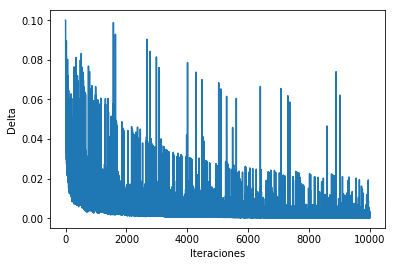

In [16]:
plt.plot(deltas)
plt.xlabel('Iteraciones')
plt.ylabel('Delta')
plt.show()

En el siguiente código, procederemos a determinar la política óptima a partir de los $Q^*$.

Para realizar este proceso, deberemos hallar los valores $V^*$ a partir de los valores de $Q^*$.

In [17]:
policy = {}
V = {}

for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

Visualizaremos por pantalla los $V^*$.

In [18]:
print("update counts:")
total = np.sum(list(update_counts.values()))

for k, v in update_counts.items():
    update_counts[k] = float(v) / total

print_values(update_counts, grid)

update counts:
---------------------------
 0.18| 0.18| 0.18| 0.00|
---------------------------
 0.18| 0.00| 0.04| 0.00|
---------------------------
 0.19| 0.02| 0.03| 0.00|


Para finalizar, procederemos a imprimir los valores de $V(s)$ finales y la política encontrada.

In [19]:
print("final values:")
print_values(V, grid)

print("\nfinal policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.50| 0.72| 1.00| 0.00|
---------------------------
 0.30| 0.00| 0.73| 0.00|
---------------------------
 0.13| 0.21| 0.44| 0.20|

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


## 4. _Q-Learning_

En este apartado, implementaremos el método _Q-learning_ para resolver el entorno __GridWorld__ (en el caso de *negative_grid*) y compararemos los resultados obtenidos con el método que hemos implementado en el apartado anterior (el método SARSA).

## 4.1. Inicialización

Cargaremos el entorno __GridWorld__ e inicializamos los parámetros del algoritmo y de sus reglas de actualización.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1

Como en el caso anterior del algoritmo SARSA, definimos el `argmax(key)` y el `max(value)`, que son variables que nos sirven para la implementación del algoritmo.

In [21]:
def max_dict(d):
    # retorna el argmax (key) y max (value) de un diccionario
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    
    return max_key, max_val

Inicializamos las acciones aleatorias.

In [22]:
def random_action(a, eps=0.1):
    # epsilon-soft para asegurar que se visiten todos los estados
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

Al igual que en el ejemplo anterior, vamos a utilizar el entorno __*negative_grid*__ que implementa una penalización por cada movimiento. De esta forma, el agente buscará el camino más corto para resolver el problema (es decir, la política óptima).

In [23]:
grid = negative_grid(step_cost=-0.1)

# emprimir rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


## 4.2. Implementación del algoritmo _Q-Learning_

Pasaremos ahora a la implementación del algoritmo. Como en el caso anterior de la implementación del algoritmo SARSA, en este caso tampoco vamos a inicializar la política, sino que inicializamos empleando los valores de $Q$ más recientes.

In [24]:
# initializar Q(s,a)
Q = {}
states = grid.all_states()

for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0

# valores iniciales de Q values para todos los estados de la cuadricula
print(Q)

{(0, 1): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (1, 2): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (0, 0): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 3): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 0): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (1, 3): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (1, 0): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 2): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (0, 3): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (0, 2): {'D': 0, 'R': 0, 'U': 0, 'L': 0}, (2, 1): {'D': 0, 'R': 0, 'U': 0, 'L': 0}}


Creamos las variables `update-counts` y `update_counts_sa` que nos serviran para saber cuantas veces actualizaremos los valores de $Q(s)$.

In [25]:
update_counts = {}
update_counts_sa = {}

for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        update_counts_sa[s][a] = 1.0

Como puede notarse, hasta este punto no pueden observarse diferencias respecto al algoritmo SARSA presentado en la sección anterior.

A continuación, implementaremos los pasos del algoritmo _Q-learning_ hasta su convergencia. Es importante notar las diferencias, aquí sí, con el ejemplo mostrado en la sección anterior.

In [26]:
# repetir hasta la convergencia
t = 1.0
deltas = []

for it in range(10000):
    if it % 100 == 0:
        t += 1e-2
    if it % 2000 == 0:
        print("iteration:", it)

    # en lugar de generar un episodio, jugaremos un episodio y lo manderemos en loop, como aquí abajo

    s = (2, 0) # estado inicial
    grid.set_state(s)

    # la primera (s,r) es el estado inicial y vale 0 
    # (dado que no tenemos un reward), para empezar el juego de manera facil.
    # la ultima (s, r) es el estado terminal y el reward final.
    # el valor por el estado terminal es por definición 0, así que no nos importa hacer una actualización.

    a, _ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over():
        a = random_action(a, eps=0.5/t) # epsilon-greedy
        # una accion random también funciona, pero sería mas lento dado que puedes chocar contra los muros
        # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
        r = grid.move(a)
        s2 = grid.current_state()

        # adaptive learning rate
        alpha = ALPHA / update_counts_sa[s][a]
        update_counts_sa[s][a] += 0.005

        # actualizaremos Q(s,a) cada vez que probamos un episodio
        old_qsa = Q[s][a]
        # la diferencia entre SARSA y Q-Learning es que Q-Learning
        # usa max[a']{ Q(s',a')} en la actualización
        # aunque no terminaremos tomando aquella acción en el paso siguiente
        a2, max_q_s2a2 = max_dict(Q[s2])
        Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        # queremos saber cuantas veces actualizamos Q(s)
        update_counts[s] = update_counts.get(s,0) + 1

        # el próximo estado será el nuevo estado
        s = s2
        a = a2
    
    deltas.append(biggest_change)

iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000


Imprimiremos los valores de delta ($\delta$) para visualizar la convergencia del algoritmo.

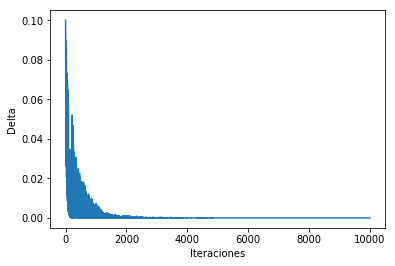

In [27]:
plt.plot(deltas)
plt.xlabel('Iteraciones')
plt.ylabel('Delta')
plt.show()

Ahora podemos determinar la política óptima a partir de $Q^*$. Para realizar este paso, deberemos encontrar $V^*$ a partir de $Q^*$. 

Estos pasos son, de nuevo, parecidos a los utilizados en la implementación del algoritmo SARSA.

In [28]:
# determinar la politica a partir de Q*
# encontra V* desde Q*
policy = {}
V = {}

for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

Visualizamos los valores de $V^*$:

In [29]:
print("update counts:")
total = np.sum(list(update_counts.values()))

for k, v in update_counts.items():
    update_counts[k] = float(v) / total

print_values(update_counts, grid)

update counts:
---------------------------
 0.03| 0.04| 0.17| 0.00|
---------------------------
 0.02| 0.00| 0.17| 0.00|
---------------------------
 0.19| 0.19| 0.18| 0.02|


Finalmente, podemos imprimir los valores de $V(s)$ finales y la política encontrada.

In [30]:
print("final values:")
print_values(V, grid)

print("\nfinal policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |
